<a href="https://colab.research.google.com/github/abhi0928/git-github/blob/master/Age__and_Gender_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omi0928","key":"6be8a6e0e10cfb70aa0e1bcb751b8a88"}'}

In [0]:
!pip -q install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ttungl/adience-benchmark-gender-and-age-classification

 99% 1.37G/1.39G [00:15<00:00, 83.9MB/s]
100% 1.39G/1.39G [00:15<00:00, 95.5MB/s]


In [0]:
# for removing any file or directory

'''for root, dirs, files in os.walk(folder_name, topdown=False):
    for name in files:
        os.remove(os.path.join(root, name))
    for name in dirs:
        os.rmdir(os.path.join(root, name))'''

In [0]:
# make a train directory and unzip all files in train directory

!mkdir train     
!unzip -q /content/adience-benchmark-gender-and-age-classification.zip -d train

# data preprocessing

In [0]:
# Importing essential libraries
import numpy as np
import pandas as pd
import glob
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
sns.set_context('talk')
from IPython.display import Image
from pathlib import Path
from tqdm import tqdm
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
# create a path for image folder
faces_path = Path('/content/train/AdienceBenchmarkGenderAndAgeClassification/faces')
print(f'number of directories in faces are {len(os.listdir(faces_path))}')

number of directories in faces are 168


In [0]:
# Loading the training data
fold_0 = pd.read_table('/content/train/AdienceBenchmarkGenderAndAgeClassification/fold_0_data.txt')
fold_1 = pd.read_table('/content/train/AdienceBenchmarkGenderAndAgeClassification/fold_1_data.txt')
fold_2 = pd.read_table('/content/train/AdienceBenchmarkGenderAndAgeClassification/fold_2_data.txt')
fold_3 = pd.read_table('/content/train/AdienceBenchmarkGenderAndAgeClassification/fold_3_data.txt')
fold_4 = pd.read_table('/content/train/AdienceBenchmarkGenderAndAgeClassification/fold_4_data.txt')

In [0]:
fold_0.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [0]:
fold_0.shape

(4484, 12)

In [0]:
# concatenate all the dataframes to a single dataframe
data = pd.concat([fold_0, fold_1, fold_2, fold_3, fold_4], ignore_index = True)

In [0]:
print(f'data has {data.shape[0]} rows and {data.shape[1]} columns')

data has 19370 rows and 12 columns


In [0]:
# get the list of all images 
train_images = glob.glob('/content/train/AdienceBenchmarkGenderAndAgeClassification/faces/**/*.jpg', recursive = True)

In [0]:
print(f'there are {len(train_images)} images in the data')

there are 19370 images in the data


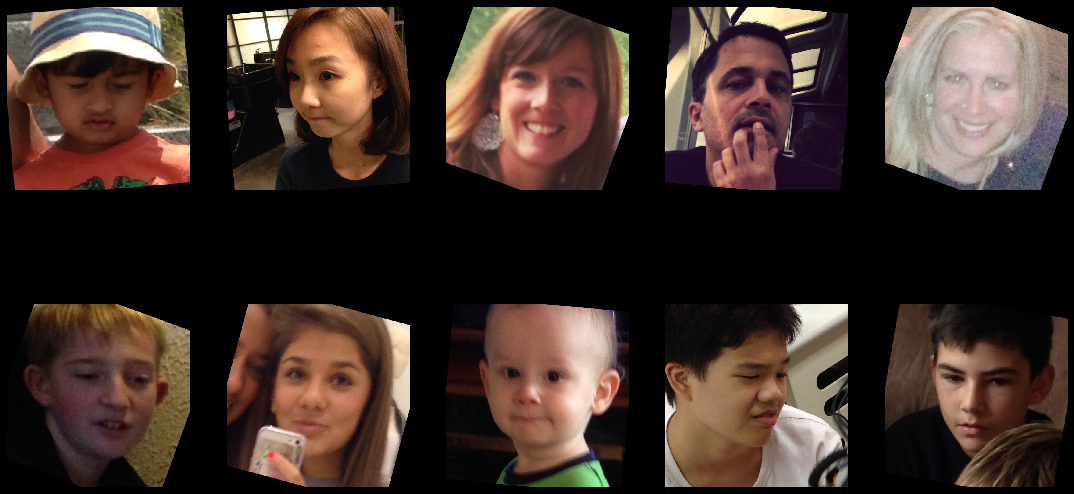

In [0]:
# Lets visualize some images  

f, ax = plt.subplots(2, 5, figsize = (19, 10))

for i in range(10):
    n = random.randrange(0, 19370, 3)     # generate a random number for acess images in random manner
    img = cv2.imread(train_images[n], 1)          # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # convert BGR to RGB forma

    ax[i//5, i%5].imshow(img)     # show image
    ax[i//5, i%5].axis('off')     # set axis off for the plot
    ax[i//5, i%5].set_aspect('equal')    # set aspect ratio for the images
plt.show()    

In [0]:
data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [0]:
train_images[0]

'/content/train/AdienceBenchmarkGenderAndAgeClassification/faces/10328235@N07/coarse_tilt_aligned_face.1173.10743841116_f90d329820_o.jpg'

In [0]:
image_path = []

for i in range(19370):
    path = 'coarse_tilt_aligned_face.' + str(data['face_id'][i]) + '.'+ str(data['original_image'][i])
    image_path.append(faces_path / str(data['user_id'].iloc[i]) / path)

In [0]:
len(image_path)

19370

In [0]:
df = pd.Series(image_path)

In [0]:
# add image_path column in the data
data = pd.concat([data, df], axis = 1)

In [0]:
# change new_feature name
data.columns = ['user_id', 'original_image', 'face_id', 'age', 'gender', 'x', 'y', 'dx', 
                'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score', 'image_path']

In [0]:
data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,image_path
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,/content/train/AdienceBenchmarkGenderAndAgeCla...
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,/content/train/AdienceBenchmarkGenderAndAgeCla...
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,/content/train/AdienceBenchmarkGenderAndAgeCla...
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,/content/train/AdienceBenchmarkGenderAndAgeCla...
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,/content/train/AdienceBenchmarkGenderAndAgeCla...


# handling missing values and outliers

In [0]:
data.isna().sum()

user_id                 0
original_image          0
face_id                 0
age                     0
gender                779
x                       0
y                       0
dx                      0
dy                      0
tilt_ang                0
fiducial_yaw_angle      0
fiducial_score          0
image_path              0
dtype: int64

In [0]:
# drop all rows which are having missing values
data.dropna(inplace = True)

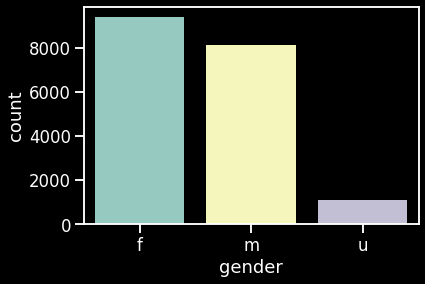

In [0]:
# lets check our labels
sns.countplot(data['gender'])

In [0]:
# there is a wrong value in the gender column so we have to remove it 

data.drop(list(data[data['gender'] == 'u'].index), inplace = True)

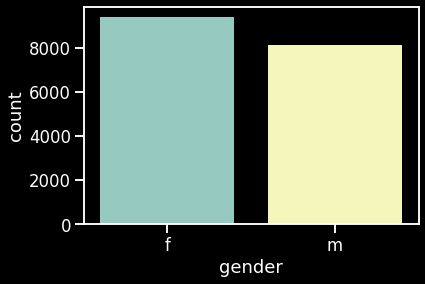

In [0]:
sns.countplot(data['gender'])

In [0]:
data['gender'].value_counts()

f    9372
m    8120
Name: gender, dtype: int64

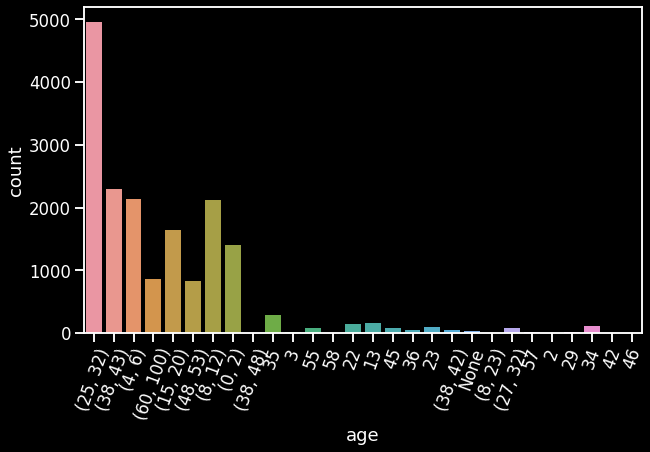

In [0]:
plt.figure(figsize = (10, 6))
sns.countplot(data['age'])
plt.xticks(rotation = '70')
plt.show()

In [0]:
# age column is not correctly labelled so we have to labelled it correctly
# (0, 2), (4, 6), (8, 12), (15, 20), (25, 32), (38, 43), (48, 53), (60, 100)

In [0]:
L = ['35', '13', '22', '34', '23', '45', '(27, 32)','55', '36', '(38, 42)', 'None', '57', '3', '29', '(38, 48)', '58', '2', '(8, 23)', '46', '42']

for i in L:
    data.drop(list(data[data['age'] == i].index), inplace = True)

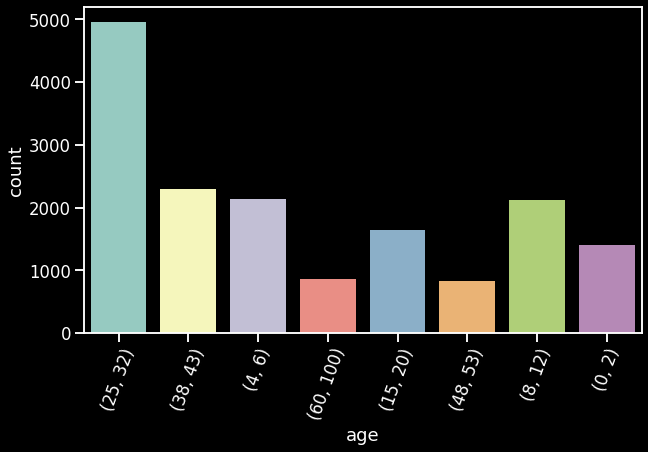

In [0]:
plt.figure(figsize = (10, 6))
sns.countplot(data['age'])
plt.xticks(rotation = '70')
plt.show()

In [0]:
# drop unwanted columns from the data

data.drop(['user_id', 'original_image', 'face_id', 'x', 'y', 'dx', 'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score'], axis = 1, inplace = True)
data.reset_index(inplace = True)

In [0]:
data.head()

,index,age,gender,image_path
0,0,"(25, 32)",f,/content/train/AdienceBenchmarkGenderAndAgeCla...
1,1,"(25, 32)",m,/content/train/AdienceBenchmarkGenderAndAgeCla...
2,2,"(25, 32)",f,/content/train/AdienceBenchmarkGenderAndAgeCla...
3,3,"(25, 32)",m,/content/train/AdienceBenchmarkGenderAndAgeCla...
4,4,"(25, 32)",m,/content/train/AdienceBenchmarkGenderAndAgeCla...


In [0]:
data.drop(['index'], axis = 1, inplace = True)

In [0]:
data.shape

(16228, 3)

# Model Selection


In [0]:
# Split the data into features and labels

X = data['image_path']
y = data.drop(['image_path'], axis = 1)

In [0]:
# reset index of features

X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

In [0]:
# function for resize images and convert into array

def get_data(df):
    X = []
    for i in tqdm(range(len(df))):
        img = cv2.imread(df[i].absolute().as_posix(), 1)   # convert posix path to string
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # convert BGR to RGB
            img = resize(img, (128, 128, 3))      # resize images into (128px, 128px, 3 channels(RGB))
            img = np.asarray(img)      # convert image into array
            img = img / 255.           # rescale image between 0-1
            X.append(img)

    X = np.asarray(X)        
    return X        

In [0]:
# resize images and convert into array

X = get_data(X)

100%|██████████| 16228/16228 [08:03<00:00, 33.60it/s]


In [0]:
# Split the data into train and validation set

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [0]:
X_train.shape, X_val.shape

((14605, 128, 128, 3), (1623, 128, 128, 3))

In [0]:
age_train = y_train.loc[:, 'age'].values
age_val = y_val.loc[:, 'age'].values

gender_train = y_train.loc[:, 'gender'].values
gender_val = y_val.loc[:, 'gender'].values

In [0]:
age_train = np.asarray(pd.get_dummies(age_train))
age_val = np.asarray(pd.get_dummies(age_val))
gender_train = np.asarray(pd.get_dummies(gender_train))
gender_val = np.asarray(pd.get_dummies(gender_val))

In [0]:
model = Sequential()

model.add(Conv2D(filters = 96, kernel_size = (7, 7), activation = 'relu', input_shape = (128, 128, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(filters = 256, kernel_size = (5, 5), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(filters = 384, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 2, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 122, 122, 96)      14208     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 96)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 57, 57, 256)       614656    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 384)       885120    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 384)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64896)            

In [67]:
model.fit_generator(X_train, gender_val, validation_data = (X_val, gender_val), epochs = 10)

Epoch 1/10


ValueError: ignored